# DTSA-5511,  Week 4: NLP Disaster Tweets Kaggle Mini-Project
### September 27, 2023


## Natural Language Processing with Disaster Tweets
### Predict which Tweets are about real disasters and which ones are not
https://www.kaggle.com/c/nlp-getting-started/overview

This jupyter notebok is uploaded to https://github.com/daisukexp/dtsa5511_week4

# Step 1 : Brief description of the problem and data

### Introduction
Natural Language Processing (NLP) is an important area in Deep Learning, It enables machines to understand, interpret, and generate human language.

In this project, we are focusing on the assignment based on a Kaggle competition that is utilizing Recurrent Neural Networks (RNNs) to analyze and categorize tweets into two categories, make a model to classify the Tweet is a real disasters or not.

The submissions are evaluated based on the F1 Score, a harmonic mean of precision and recall, providing a balance between false positives and false negatives. The F1 Score is formulated as follows,

$$F1 = 2 * \frac{{\text{precision} * \text{recall}}}{{\text{precision} + \text{recall}}}$$

The dataset provided for this project as follows,
### Files
- train.csv: The training dataset. It contains the labels indicating whether a tweet is about a real disaster (1) or not (0).
- test.csv: The test dataset and it is used to evaluate the model's performance. It does not contain the labels.

### Columns
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [351]:
import sys
import platform
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import gc
import math
import json
import nltk
import tensorflow as tf
import keras_nlp
import re

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam

train_on_gpu = True

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('averaged_perceptron_tagger')

warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = Warning)

In [352]:
sys.version

'3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]'

In [329]:
tf.__version__

'2.10.1'

In [330]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [331]:
train_on_gpu = tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)
if train_on_gpu & train_on_gpu:
    print("GPU is available.")
    !nvidia-smi
else:
    print("Training on CPU.")

GPU is available.
Tue Sep 26 16:27:22 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.42                 Driver Version: 537.42       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   52C    P5              21W / 200W |  11662MiB / 12282MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-------

# Step 2 : Exploratory Data Analysis(EDA) - Inspect, Visualize and Clean the Data


### Initial inspection  and visualizing the dataset

In [332]:
df_train = pd.read_csv('data/nlp-getting-started/train.csv')
df_test= pd.read_csv('data/nlp-getting-started/test.csv')

df_train_1 = df_train[df_train['target'] == 1]
df_train_0 = df_train[df_train['target'] == 0]

In [333]:
df_train.shape

(7613, 5)

In [334]:
df_test.shape

(3263, 4)

Real disaster:  3271
Not a Real disaster:  4342


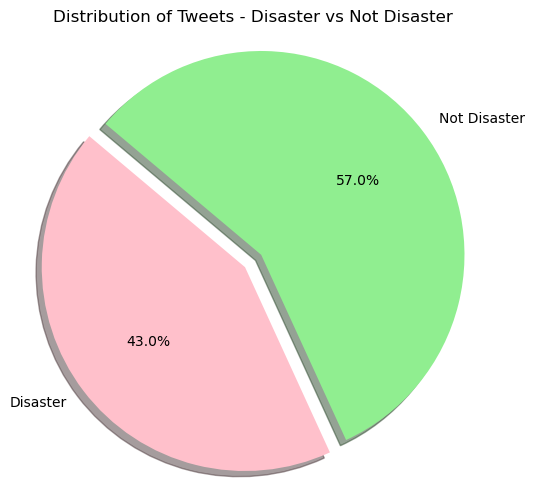

In [335]:
df_train_target_1 = df_train[df_train['target'] == 1]
df_train_target_0 = df_train[df_train['target'] == 0]
print('Real disaster: ', count_target_1)
print('Not a Real disaster: ', count_target_0)

labels = 'Disaster', 'Not Disaster'
colors = ['pink','lightgreen']
explode = (0.1, 0)
sizes = [df_train_target_1.shape[0], df_train_target_0.shape[0]]

# Plot
plt.figure(figsize=(6,6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal') 
plt.title('Distribution of Tweets - Disaster vs Not Disaster')
plt.show()

The training dataset consists of 7,613 entries, of which 3,271 are labeled as real disasters and 4,342 are not labeled as real disasters. Additionally, there are 3,263 entries in the test dataset.

In [336]:
df_train_1.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [337]:
df_train_0.head(10)

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
20,31,NaN,NaN,this is ridiculous....,0
21,32,NaN,NaN,London is cool ;),0
22,33,NaN,NaN,Love skiing,0
23,34,NaN,NaN,What a wonderful day!,0
24,36,NaN,NaN,LOOOOOOL,0


In [338]:
df_test.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [339]:
keyword_1 = df_train_target_1['keyword'].value_counts().head(20)
keyword_0 = df_train_target_0['keyword'].value_counts().head(20)

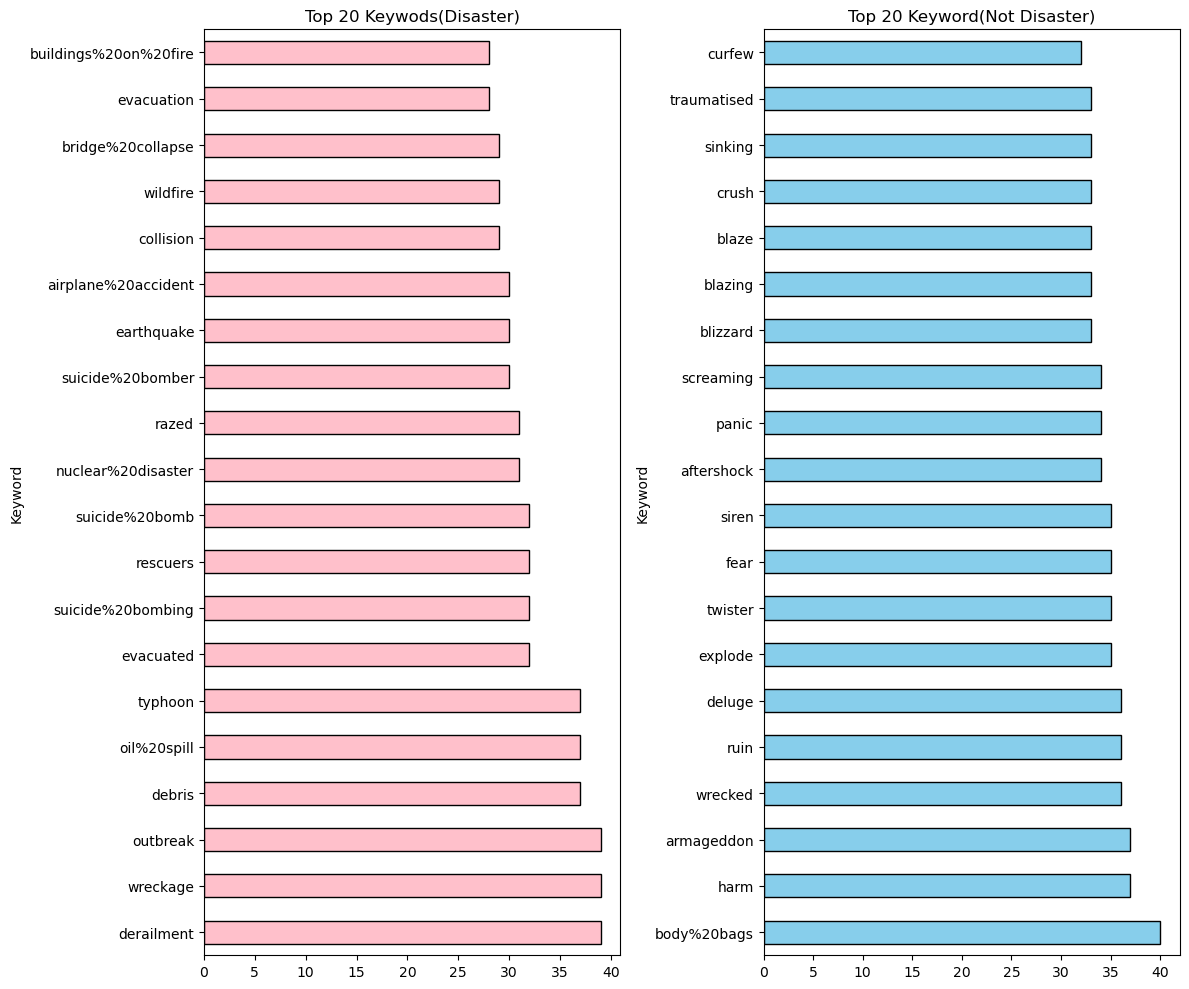

In [340]:
plt.figure(figsize=(12,10))

plt.subplot(1, 2, 1)
keyword_1.plot(kind='barh', color='pink', edgecolor='black')
plt.title('Top 20 Keywods(Disaster)')
plt.ylabel('Keyword')

plt.subplot(1, 2, 2)
keyword_0.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Top 20 Keyword(Not Disaster)')
plt.ylabel('Keyword')

plt.tight_layout()
plt.show()

In [341]:
location_1 = df_train_target_1['location'].value_counts().head(10)
location_0 = df_train_target_0['location'].value_counts().head(10)

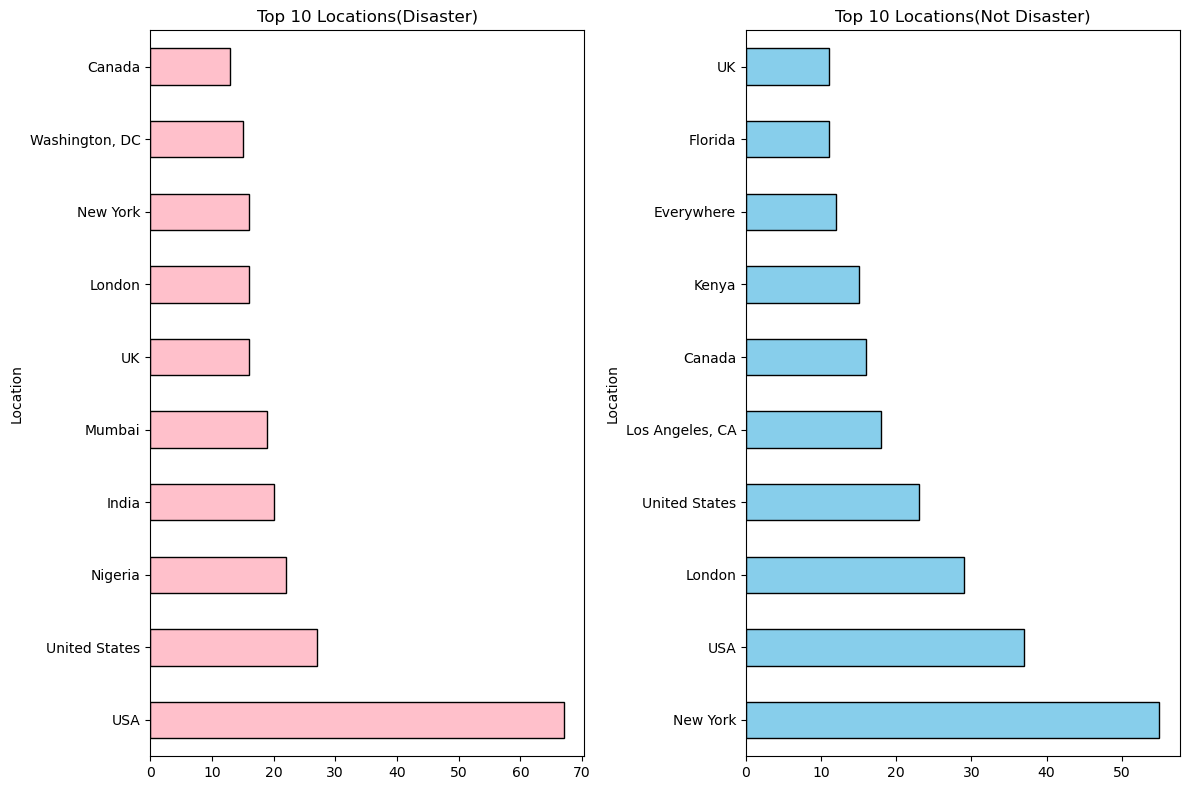

In [342]:
plt.figure(figsize=(12,8))

plt.subplot(1, 2, 1)
location_1.plot(kind='barh', color='pink', edgecolor='black')
plt.title('Top 10 Locations(Disaster)')
plt.ylabel('Location')

plt.subplot(1, 2, 2)
location_0.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Top 10 Locations(Not Disaster)')
plt.ylabel('Location')

plt.tight_layout()
plt.show()

Below are our initial observations made through manual analysis:

- text: It provides comprehensive information that can help in distinguishing whether a tweet is about a real disaster or not.
- keyword: Negative words are observed in both Disaster and Non-Disaster cases.
- location: No apparent signature or distinctive pattern related to disasters has been found.

### Data Cleaning

Remove unnecessary columns.

In [343]:
df_train.isnull().sum() 

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [344]:
df_train_data = df_train.drop(columns=['id'], axis = 1)
df_test_data = df_test.drop(columns=['id'], axis = 1)

In [354]:
def cleaning_text(row_text):
    sw = set(stopwords.words('english'))
    ps = PorterStemmer() 

    # tokenize the word using nltk  
    cleaned_text = nltk.word_tokenize(row_text)

    # remove stop words 
    cleaned_text = [word for word in cleaned_text.split() if word not in sw]
    
    # remove non English characters and lower case 
    cleaned_text = re.sub('[^A-Za-z0-9]+', " ", row_text).lower().strip()

    # stemming
    cleaned_text = [ps.stem(word) for word in cleaned_text]

    # convert back to sentence
    cleaned_text = ' '.join(cleaned_text)

    return cleaned_text

In [318]:
df_train_data['text'] = df_train_data['text'].apply(cleaning_text)

df_test_data['text'] = df_test_data['text'].apply(cleaning_text)

df_train_data.head()

,keyword,location,text,target
0,NaN,NaN,deed reason earthquak may allah forgiv us,1
1,NaN,NaN,forest fire near la rong sask canada,1
2,NaN,NaN,resid ask shelter place notifi offic evacu she...,1
3,NaN,NaN,13 000 peopl receiv wildfir evacu order califo...,1
4,NaN,NaN,got sent photo rubi alaska smoke wildfir pour ...,1


The 'id' column was dropped from the training dataset. Initially, 'keyword' and 'location' also seemed to be not useful, however, it was decided to retain these columns. Furthermore, the data underwent cleaning processes including tokenization, removal of stop words, and stemming.

# Step 3 : Model Architecutre

## 3.1 Model selection
Several NLP models are available through TensorFlow, including LSTM, BERT, KerasNLP and others. For this project, we have chosen to implement the LSTM (Long Short-Term Memory) model. LSTM models are well-suited for classification tasks involving sequence data like text, owing to their ability to remember long-term dependencies in the sequence, which can be crucial for understanding the contextual meaning of words and sentences in NLP tasks.

### LSTM
The standard LSTM model is versatile and suitable for a variety of classification tasks, providing flexibility to construct models tailored to specific needs.


### LSTM with Early Stopping
Building upon the standard LSTM model, we will incorporate an early stopping callback during training to monitor whether the model's accuracy is improving. Overfitting is a common issue in machine learning models, and implementing early stopping can mitigate overfitting to a certain extent by halting the training process when the model’s performance ceases to improve on a held-out validation dataset.


### LSTM with Early Stopping and Remove suspicous unnecessary columns 
The presence of the 'keyword' and 'location' columns poses a question regarding their contribution to the improvement of model accuracy. The immediate impact of these columns is not straightforward; hence, we will omit these columns in one of our model iterations to evaluate whether their absence enhances model performance.

### 3.1.1 LSTM

To begin with, we construct an LSTM model with a commonly used architecture, referring to the following NLTP tutorials, as shown in the following links.


https://pieriantraining.com/tensorflow-lstm-example-a-beginners-guide/

https://medium.com/mlearning-ai/the-classification-of-text-messages-using-lstm-bi-lstm-and-gru-f79b207f90ad

#### Model Description
The developed model is a Sequential model utilizing Long Short-Term Memory (LSTM) layers, suitable for binary classification tasks on sequence data, like text. This model is built using TensorFlow and Keras, intending to categorize text data from a dataset into one of two classes: '0' or '1'.

The model architecute is as follows,
- Embedding Layer: The first layer is an Embedding layer with an input dimension of 10,000, output dimension of 160, and input length of 100. This layer transforms the integer representation of words into dense vectors of fixed size, 160 in this case.
- Spatial Dropout Layer: Followed by the Embedding layer, a Spatial Dropout1D layer is used with a dropout rate of 0.2 to reduce overfitting and improve model generalization by dropping out entire 1D feature maps.
- LSTM Layer: The next layer is an LSTM layer with 128 units, capable of learning long-term dependencies in the input sequences.
- Dropout Layer: Another Dropout layer with a rate of 0.2 is added to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.
- Dense Layer: Finally, a Dense layer with a single unit and a sigmoid activation function is used to output the probability of the positive class.

In [319]:
vocab_size = 10000
max_len = 100

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(df_train_data['text'])

X = tokenizer.texts_to_sequences(df_train_data['text'])
X = pad_sequences(X, maxlen = max_len)

#spliting data into train and validate
X_train, X_val, y_train, y_val = train_test_split(X, df_train_data['target'], test_size = 0.2, random_state = 123)

In [346]:
#Building lstm model
embedding_dim = 160
n_lstm = 128
drop_lstm = 0.2

model_lstm = Sequential()

# Define LSTM Model 
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model_lstm.add(SpatialDropout1D(drop_lstm))
model_lstm.add(LSTM(n_lstm, return_sequences = False))
model_lstm.add(Dropout(drop_lstm))
model_lstm.add(Dense(1, activation = 'sigmoid'))

In [362]:
model_lstm.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

model_lstm.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 100, 160)          1600000   
                                                                 
 spatial_dropout1d_17 (Spati  (None, 100, 160)         0         
 alDropout1D)                                                    
                                                                 
 lstm_22 (LSTM)              (None, 128)               147968    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,748,097
Trainable params: 1,748,097
Non-trainable params: 0
___________________________________________

The model is trained for 10 epochs using a batch size of 100. The training data is split into training and validation subsets, with the model being evaluated on the validation subset at the end of each epoch to monitor its performance and generalization capability.

This model, with its combination of embedding, dropout regularization, and LSTM layers, is adept at processing sequence data and is expected to perform well on tasks involving the classification of text sequences.

In [363]:
batch_size = 100 
train_epochs = 10 

history_lstm = model_lstm.fit(X_train, y_train,
                              epochs = train_epochs,
                              batch_size = batch_size,
                              validation_data = (X_val, y_val)
                             )

Epoch 1/10
61/61 [==============================] - 2s 15ms/step - loss: 0.6767 - accuracy: 0.5724 - val_loss: 0.6582 - val_accuracy: 0.5772
Epoch 2/10
61/61 [==============================] - 0s 8ms/step - loss: 0.6498 - accuracy: 0.5997 - val_loss: 0.6323 - val_accuracy: 0.6592
Epoch 3/10
61/61 [==============================] - 0s 8ms/step - loss: 0.6127 - accuracy: 0.6826 - val_loss: 0.5988 - val_accuracy: 0.6842
Epoch 4/10
61/61 [==============================] - 0s 8ms/step - loss: 0.5641 - accuracy: 0.7225 - val_loss: 0.5484 - val_accuracy: 0.7439
Epoch 5/10
61/61 [==============================] - 0s 8ms/step - loss: 0.4571 - accuracy: 0.7982 - val_loss: 0.4648 - val_accuracy: 0.7866
Epoch 6/10
61/61 [==============================] - 1s 8ms/step - loss: 0.3556 - accuracy: 0.8542 - val_loss: 0.4594 - val_accuracy: 0.7912
Epoch 7/10
61/61 [==============================] - 1s 8ms/step - loss: 0.3038 - accuracy: 0.8768 - val_loss: 0.4485 - val_accuracy: 0.8030
Epoch 8/10
61/61 [=

### 3.2.1 LSTM with Ealry Stopping

In [371]:
model_lstm_es = Sequential()
model_lstm_es.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model_lstm_es.add(SpatialDropout1D(drop_lstm))
model_lstm_es.add(LSTM(n_lstm, return_sequences = False))
model_lstm_es.add(Dropout(drop_lstm))
model_lstm_es.add(Dense(1, activation  ='sigmoid'))

model_lstm_es.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True)

history_lstm_es = model_lstm_es.fit(X_train, y_train,
                                    epochs = 100,
                                    batch_size = batch_size,
                                    validation_data = (X_val, y_val),
                                    callbacks = [early_stopping]
                                  )

Epoch 1/100
61/61 [==============================] - 2s 15ms/step - loss: 0.6784 - accuracy: 0.5744 - val_loss: 0.6605 - val_accuracy: 0.5778
Epoch 2/100
61/61 [==============================] - 1s 9ms/step - loss: 0.6495 - accuracy: 0.5966 - val_loss: 0.6293 - val_accuracy: 0.6540
Epoch 3/100
61/61 [==============================] - 1s 9ms/step - loss: 0.6093 - accuracy: 0.6837 - val_loss: 0.5924 - val_accuracy: 0.6855
Epoch 4/100
61/61 [==============================] - 1s 8ms/step - loss: 0.5474 - accuracy: 0.7383 - val_loss: 0.5359 - val_accuracy: 0.7485
Epoch 5/100
61/61 [==============================] - 1s 8ms/step - loss: 0.4311 - accuracy: 0.8172 - val_loss: 0.4677 - val_accuracy: 0.7905
Epoch 6/100
61/61 [==============================] - 1s 8ms/step - loss: 0.3497 - accuracy: 0.8567 - val_loss: 0.4574 - val_accuracy: 0.8037
Epoch 7/100
61/61 [==============================] - 1s 8ms/step - loss: 0.3071 - accuracy: 0.8767 - val_loss: 0.4584 - val_accuracy: 0.8083
Epoch 8/100


### 3.3.1 LSTM with Ealry Stopping and dropped keyword/location

In [374]:
df_train_data_drop = df_train.drop(columns=['id', 'location', 'keyword'], axis = 1)
df_test_data_drop = df_test.drop(columns=['id', 'location', 'keyword'], axis = 1)

X_train, X_val, y_train, y_val = train_test_split(X, df_train_data_drop['target'], test_size = 0.2, random_state = 123)

model_lstm_es_drop = Sequential()
model_lstm_es_drop.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model_lstm_es_drop.add(SpatialDropout1D(drop_lstm))
model_lstm_es_drop.add(LSTM(n_lstm, return_sequences = False))
model_lstm_es_drop.add(Dropout(drop_lstm))
model_lstm_es_drop.add(Dense(1, activation  ='sigmoid'))

model_lstm_es_drop.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True)

history_lstm_es_drop = model_lstm_es_drop.fit(X_train, y_train,
                                    epochs = 100,
                                    batch_size = batch_size,
                                    validation_data = (X_val, y_val),
                                    callbacks = [early_stopping]
                                  )

Epoch 1/100
61/61 [==============================] - 2s 15ms/step - loss: 0.6820 - accuracy: 0.5593 - val_loss: 0.6612 - val_accuracy: 0.5772
Epoch 2/100
61/61 [==============================] - 1s 8ms/step - loss: 0.6475 - accuracy: 0.6056 - val_loss: 0.6279 - val_accuracy: 0.6645
Epoch 3/100
61/61 [==============================] - 1s 9ms/step - loss: 0.6129 - accuracy: 0.6801 - val_loss: 0.5967 - val_accuracy: 0.6894
Epoch 4/100
61/61 [==============================] - 1s 9ms/step - loss: 0.5589 - accuracy: 0.7322 - val_loss: 0.5436 - val_accuracy: 0.7505
Epoch 5/100
61/61 [==============================] - 1s 9ms/step - loss: 0.4340 - accuracy: 0.8144 - val_loss: 0.4784 - val_accuracy: 0.7800
Epoch 6/100
61/61 [==============================] - 1s 9ms/step - loss: 0.3449 - accuracy: 0.8604 - val_loss: 0.4578 - val_accuracy: 0.8063
Epoch 7/100
61/61 [==============================] - 1s 9ms/step - loss: 0.3018 - accuracy: 0.8772 - val_loss: 0.4627 - val_accuracy: 0.8063
Epoch 8/100


# Step 4 : Results and Analysis

In this step, we evaluate the performance of the three distinct models we have developed: the Standard LSTM model, the LSTM model with Early Stopping, and the model trained with a reduced feature set by removing some columns from the training dataset. The predictions will be submitted to Kaggle for evaluation.

### Helper functions

Plot accuracy and loss

In [174]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
    plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_lstm.history['loss'], label='Training Loss')
    plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

Predict test dataset

In [357]:
# to be completed
def predict_test(model, file_submit, df_test_data):
    X_test = tokenizer.texts_to_sequences(df_test_data['text'])
    X_test = pad_sequences(X_test, maxlen=100)

    # predict output using the test images on our model
    predictions = model.predict(X_test)
    
    # Create data to submission
    prediction_values = predictions.flatten()
    predictions_result = (prediction_values >= 0.5).astype(int)

    predictions_result = pd.DataFrame({'id': df_test['id'],'target': predictions_result})

    predictions_result['target'].value_counts()

    # Save the csv file
    predictions_result.to_csv(file_submit, index=False)

## 4.1 LSTM

In [364]:
loss, accuracy = model_lstm.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

Validation Accuracy: 80.30%
Validation Loss: 0.5000


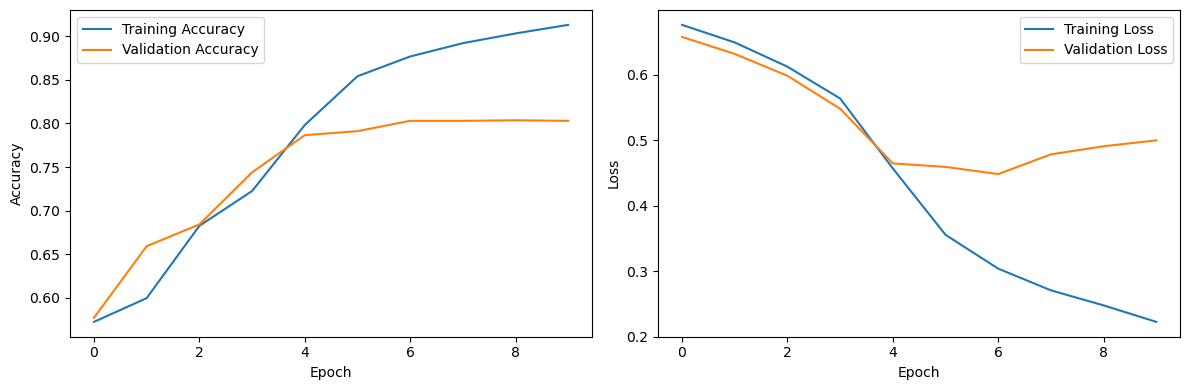

In [365]:
plot_history(history_lstm)

In [360]:
predict_test(model_lstm, 'data/my_submission_lstm.csv', df_test_data)

102/102 [==============================] - 0s 5ms/step


Kaggle score is 0.76248

The LSTM model showed good performance with a validation accuracy of 80.30%, and a validation loss of 0.5000, considered this model is capable of predictinfg unseen data reasonablly.

## 4.2 LSTM Early Stop

In [372]:
loss, accuracy = model_lstm_es.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

Validation Accuracy: 80.37%
Validation Loss: 0.4574


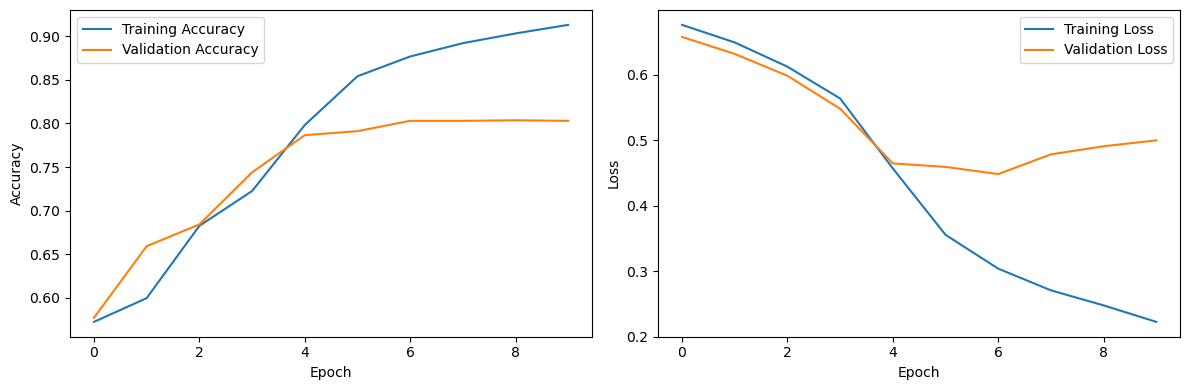

In [373]:
plot_history(history_lstm_es_drop)

In [295]:
predict_test(model_lstm_es, 'data/my_submission_lstm_es.csv', df_test_data)

102/102 [==============================] - 0s 4ms/step


Kaggle score is 0.79037.

The LSTM with Ealry Stop did not show significant improvement to previous standard LSTM model with a validation accuracy is 80.37% and a validation loss is 0.4574. This suggested that overfitting is not a major factor to our LSTM model.

## 4.3 LSTM with Early Stop and removing unuseful columns

In [375]:
loss, accuracy = model_lstm_es_drop.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

Validation Accuracy: 80.63%
Validation Loss: 0.4578


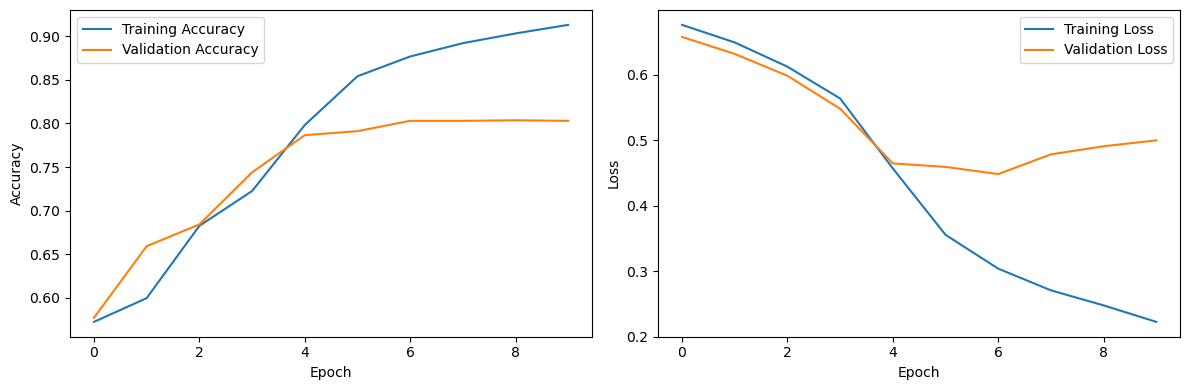

In [376]:
plot_history(history_lstm_es_drop)

In [298]:
predict_test(model_lstm_es, 'data/my_submission_lstm_es_drop.csv', df_test_data_drop)

102/102 [==============================] - 0s 3ms/step


Kaggle score is 0.73735.

The LSTM with Early Stop and drop unuseful columns did not show big differences compared to previous two models. This supports our assumption of 'keyword' and 'location' are unuseful.

## 4.4 Analysis

All three models are demonstrated reasonable accuracy on the training dataset in the task of classifying tweets related to disasters. The performance metrics across the three models were relatively similar, indicating that the architecture and construction of the model play pivotal roles in determining overall performance and effectiveness in classification tasks.


The Kaggle scores for the models are as follows:

- LSTM baseline: 0.76248
- LSTM with Early Stop: 0.79037
- LSTM with Early Stop and removing unuseful columns: 0.73735

These scores reveal a notable aspect: despite their similar performances on the training dataset, the models exhibited varying degrees of effectiveness on unseen data. Specifically, the LSTM with Early Stop model outperformed the others, suggesting that incorporating early stopping enhanced the model's ability to generalize, thus improving its reliability on new, unseen data. Conversely, the model where potentially unuseful columns were removed displayed a lower score, indicating that the excluded features might have had some relevance or contribution to the classification task.

# Step 5 : Conclusion

In conclusion, we have validated three models based on standard LSTM, each exhibiting no significant differences in performance on the training dataset but revealing variations when applied to the test dataset. The Kaggle scores, being closely aligned, signify that the models maintained a consistent performance level across both the training and test datasets, reflecting their stable generalization capabilities.

The similarity in performance metrics indicates that the models responded with equal proficiency to the unseen data, highlighting the importance of model construction.

In future work, we plan to delve deeper into experimenting with different architectures, exploring variations and combinations of models like BERT for its capability to understand the context of words in search queries and content better, Transformer models for their attention mechanisms that weigh the importance of different words in input sequences.

By investigating these diverse architectures, we aim to further refine our models, enhance their predictive accuracies, and explore the vast possibilities and potentials that advanced NLP models hold in the realm of text classification and beyond.

![Kaggle Score](dtsa5511_week4_kaggle_submit.png)

# Reference
- https://keras.io/keras_nlp/
- https://pieriantraining.com/tensorflow-lstm-example-a-beginners-guide/
- https://medium.com/mlearning-ai/the-classification-of-text-messages-using-lstm-bi-lstm-and-gru-f79b207f90ad